In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import pandas_ta as ta

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
# 添加缺失的vwap字段（如果未提供）
if 'vwap' not in df.columns:
    df['vwap'] = df['turnover'] / df['volume']

In [4]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [5]:
def calculate_trend_strength_composite(df, rsi_window=14, trend_window=50):
    """
    趋势强度复合因子
    金融学原理：
    1. 在强趋势中上影线信号失效（趋势>1.5倍标准差）
    2. 结合ADX识别真实反转点
    3. 波动收缩期(低BB width)的上影线更具预测性
    """
    # 计算趋势强度
    ma = df['close'].rolling(trend_window).mean()
    std = df['close'].rolling(trend_window).std()
    df['trend_strength'] = (df['close'] - ma) / std
    
    # 计算ADX
    df['adx'] = ta.adx(df['high'], df['low'], df['close'], length=14)['ADX_14']
    
    # 计算布林带宽度
    bbands = ta.bbands(df['close'], length=20)
    df['bb_width'] = (bbands['BBU_20_2.0'] - bbands['BBL_20_2.0']) / bbands['BBM_20_2.0']
    
    # 基础因子
    max_open_close = np.maximum(df['open'], df['close'])
    base_factor = (df['high'] - max_open_close) / df['open']
    
    # 信号增强条件
    return np.where(
        (df['adx'] < 25) &                   # 非强趋势市场
        (df['bb_width'] < 0.05) &            # 低波动环境
        (np.abs(df['trend_strength']) < 1.5), # 非极端趋势
        base_factor * 2.0,
        base_factor * 0.5
    )

# 因子测试

In [6]:
evaluator.set_factor(
    factor_data_or_func=calculate_trend_strength_composite,
    factor_name='calculate_trend_strength_composite'
)


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.016733
   Rank_IC (Spearman): 0.010097
📊 信息比率:
   IR: 0.407974
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 130696
   因子列: calculate_trend_strength_composite
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


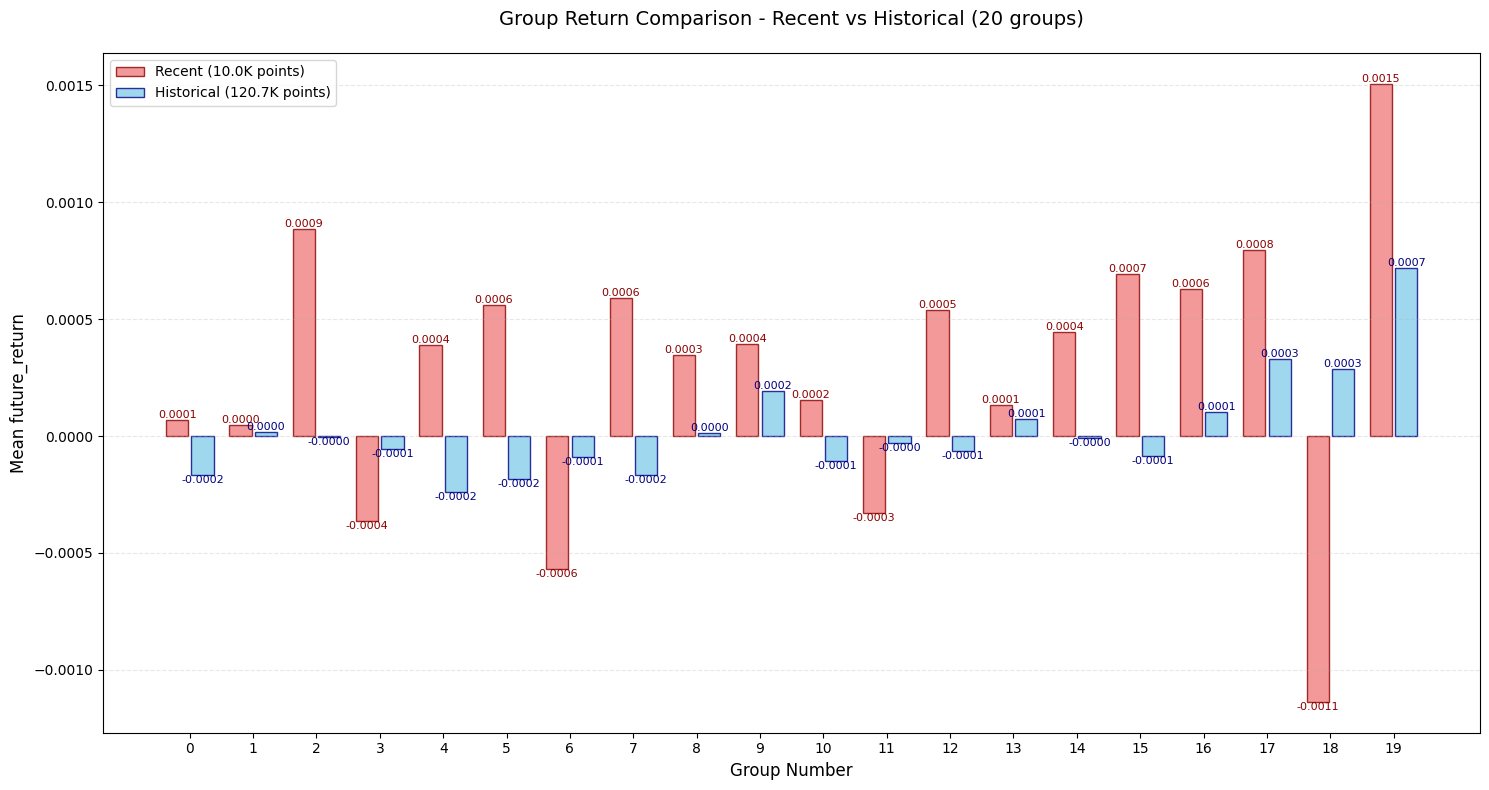

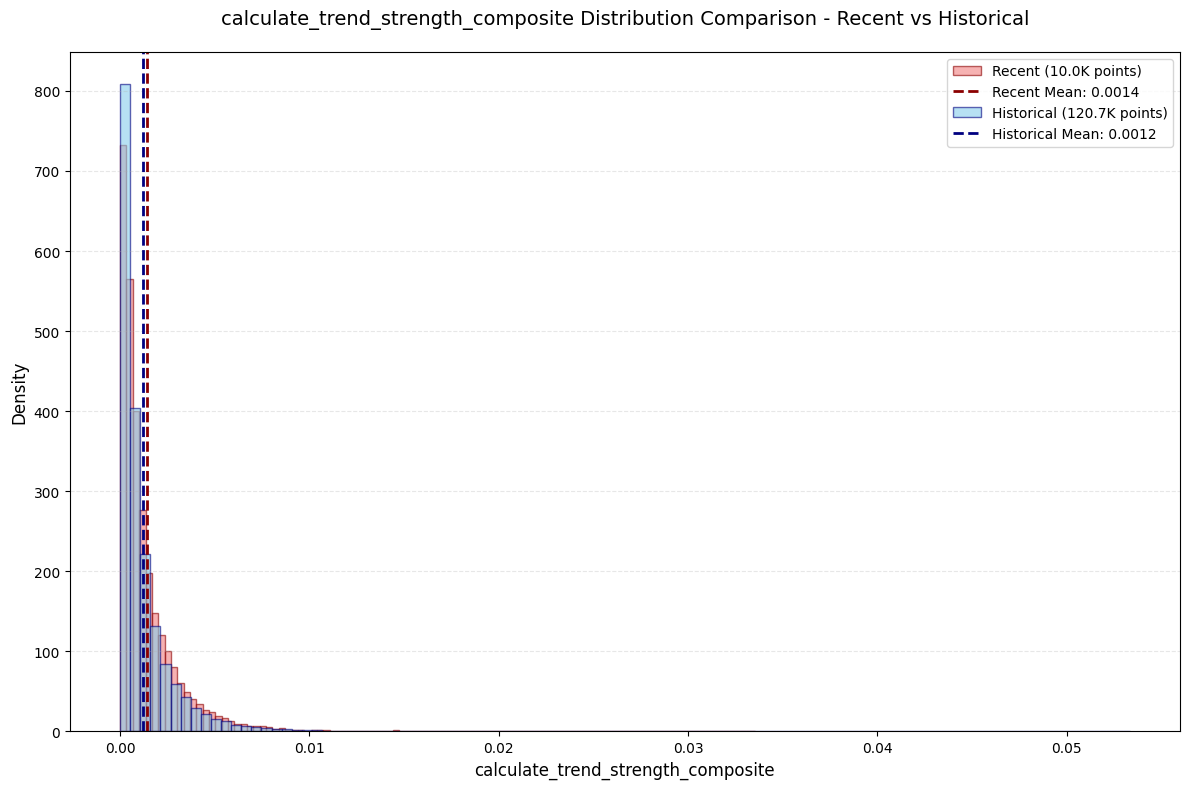

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [7]:
result=evaluator.run_full_evaluation(run_stationarity_test=False)